In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io
from scipy.interpolate import interp1d
# !pip install geopandas
import geopandas as gpd



In [2]:
import os
os.getcwd()

'/Users/ntaverna/Documents/DEEPEN/PFA Data Manipulation/project 3D to 2D_DEEPEN'

In [3]:
nnvm_boundary = gpd.read_file("/Users/ntaverna/Documents/DEEPEN/PFA Data Manipulation/project 3D to 2D_DEEPEN/national_monument_boundary/NNVM_bounds.shp")
nnvm_boundary_buffer = gpd.read_file("/Users/ntaverna/Documents/DEEPEN/PFA Data Manipulation/project 3D to 2D_DEEPEN/national_monument_boundary/NNVM_500m_Buffer.shp")
# print(nnvm_boundary.geometry[0])
nnvm_boundary = gpd.GeoSeries([nnvm_boundary.geometry[0]])
nnvm_boundary_buffer = gpd.GeoSeries([nnvm_boundary_buffer.geometry[0]])

hydrothermal_available_area = gpd.read_file("/Users/ntaverna/Documents/DEEPEN/PFA Data Manipulation/project 3D to 2D_DEEPEN/available_resource_area/Hydrothermal_Available_area.shp")
hydrothermal_available_area = gpd.GeoSeries([hydrothermal_available_area.geometry[0]])

egs_available_area = gpd.read_file("/Users/ntaverna/Documents/DEEPEN/PFA Data Manipulation/project 3D to 2D_DEEPEN/available_resource_area/EGS_Available area.shp")
egs_available_area = gpd.GeoSeries([egs_available_area.geometry[0]])

wells = pd.read_csv('Newberry Model Wells_location.csv')

In [4]:
# import data
file_path = 'Hydrothermal Block Model_with Components.csv'
xcol = 'X'
ycol = 'Y'
zcol = 'Z'
valcol1 = 'HT_Favorability_expert'
# valcol2 = 'HT_Favorability_stats'

full_data = pd.read_csv(file_path,na_values=['WOV','OUT','BLK','ERR'])

# sort by x,y,z just in case data points are out of order
full_data = full_data.sort_values(by=[xcol,ycol,zcol])
full_data = full_data.reset_index(drop=True)

In [5]:
# take the sum of each column
full_data_df = pd.DataFrame(full_data)
sums = full_data_df.groupby([xcol,ycol],as_index=False).sum()

x = sums['X']
y = sums['Y']

xlim = x
ylim = y

# Uncertainty
## Hydrothermal Uncertainty

### Read in file

In [6]:
# import data
file_path = 'Uncertainty - Hydrothermal NEW GRID.csv'
xcol = 'X'
ycol = 'Y'
zcol = 'Z'
valcol1 = 'HT Uncertainty Expert'
# valcol2 = 'HT_Favorability_stats'

full_data_ht_uncert = pd.read_csv(file_path,na_values=['WOV','OUT','BLK','ERR'])

# sort by x,y,z just in case data points are out of order
full_data_ht_uncert = full_data_ht_uncert.sort_values(by=[xcol,ycol,zcol])
full_data_ht_uncert = full_data_ht_uncert.reset_index(drop=True)
full_data_ht_uncert.head(10)

,X,Y,Z,HT Heat Uncertainty Expert,HT Reservoir Uncertainty Expert,HT Uncertainty Expert
0,623246.4,4823247.1,-24148,NaN,0.696169,NaN
1,623246.4,4823247.1,-23648,NaN,0.697013,NaN
2,623246.4,4823247.1,-23148,NaN,0.698054,NaN
3,623246.4,4823247.1,-22648,NaN,0.699281,NaN
4,623246.4,4823247.1,-22148,NaN,0.700681,NaN
5,623246.4,4823247.1,-21648,NaN,0.701576,NaN
6,623246.4,4823247.1,-21148,NaN,0.702325,NaN
7,623246.4,4823247.1,-20648,NaN,0.703184,NaN
8,623246.4,4823247.1,-20148,NaN,0.704152,NaN
9,623246.4,4823247.1,-19648,NaN,0.705219,NaN


### Plot in 3D for Sanity Check

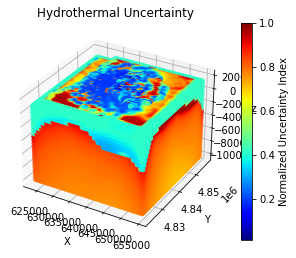

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = ax.scatter(full_data_ht_uncert[xcol], 
           full_data_ht_uncert[ycol], 
           full_data_ht_uncert[zcol],
          c=full_data_ht_uncert[valcol1],
          cmap='jet')
plt.title('Hydrothermal Uncertainty')
fig.colorbar(img, ax=ax,label='Normalized Uncertainty Index')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [8]:
full_data_ht_uncert.shape


(226438, 6)

### Project onto 2D Surface by summing values across all depths at each point on the surface

In [9]:
# take the sum of each column
full_data_ht_uncert_df = pd.DataFrame(full_data_ht_uncert)
sums_ht_uncert = full_data_ht_uncert_df.groupby([xcol,ycol],as_index=False).sum()


### Plot in 2D

/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/4015474773.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(xticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/4015474773.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(yticks,fontsize= 12)


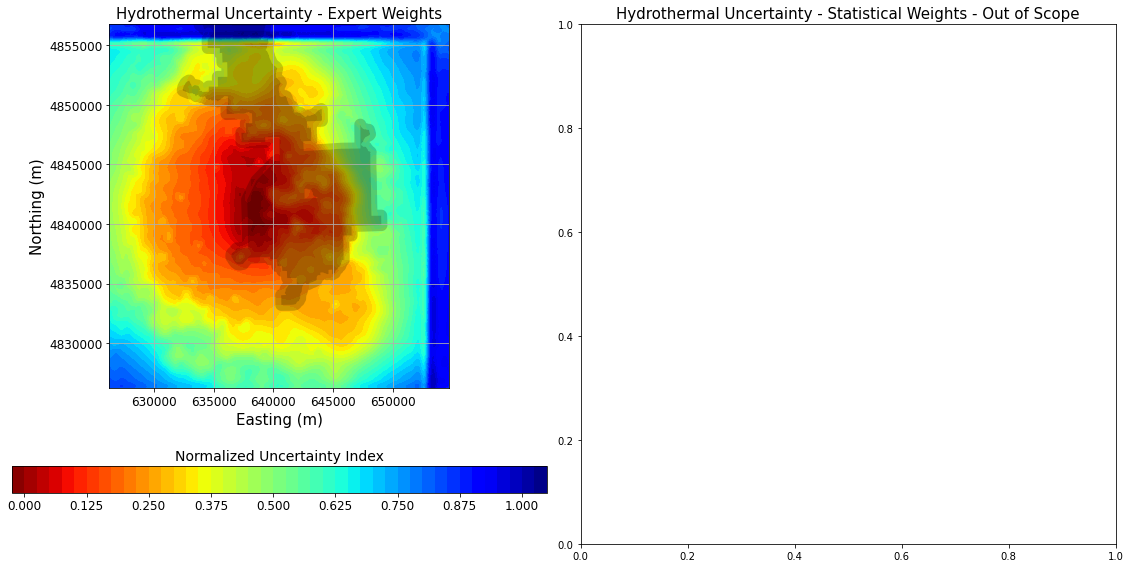

In [10]:
x = sums_ht_uncert['X']
y = sums_ht_uncert['Y']
xi = np.linspace(x.min(),x.max(),500)
yi = np.linspace(y.min(),y.max(),500)
z = sums_ht_uncert['HT Uncertainty Expert'] - sums_ht_uncert['HT Uncertainty Expert'].min()
z = z/z.max()
xv,yv = np.meshgrid(xi,yi)
grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')

fig,ax=plt.subplots(1,2,figsize=(16,8))

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s}"

img = ax[0].contourf(xi,yi,grid,cmap='jet_r',levels=50)
# img2 = ax[0].contour(x,y,grid,colors=['lightgrey'])
# ax[0].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
xticks = [625000,630000,635000,640000,645000,650000]
yticks = [4825000, 4830000,4835000, 4840000,4845000,4850000,4855000]
ax[0].set_xlabel('Easting (m)',fontsize = 15)
ax[0].set_ylabel('Northing (m)',fontsize = 15)
ax[0].set_xticklabels(xticks,fontsize= 12)
ax[0].set_yticklabels(yticks,fontsize= 12)
ax[0].set_title('Hydrothermal Uncertainty - Expert Weights',fontsize = 15)
ax[0].xaxis.grid(True, zorder=0)
ax[0].yaxis.grid(True, zorder=0)
nnvm_boundary.plot(ax=ax[0], color='black', alpha = 0.35)
nnvm_boundary_buffer.plot(ax=ax[0], color='black', alpha = 0.2)
ax[0].set_xlim(xlim.min(), xlim.max())
ax[0].set_ylim(ylim.min(), ylim.max())
cbar = fig.colorbar(img, ax=ax[0],orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Normalized Uncertainty Index',fontsize=14)

# z = sums_ht_uncert['EGS_Favorability_stats'] - sums_ht_uncert['EGS_Favorability_stats'].min()
# z = z/z.max()
# grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')
# img = ax[1].contourf(x,y,grid,cmap='jet')
# # img2 = ax[1].contour(x,y,grid,colors=['lightgrey'])
# # ax[1].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
# ax[1].set_xlabel('Easting (m)')
# ax[1].set_ylabel('Northing (m)')
ax[1].set_title('Hydrothermal Uncertainty - Statistical Weights - Out of Scope',fontsize = 15)
# fig.colorbar(img, ax=ax[1])

plt.tight_layout()
plt.show()

### Write 2D Projection to CSV

In [11]:
sums_ht_uncert.to_csv('2D_'+file_path)

## EGS Uncertainty

### Read in file

In [12]:
# import data
file_path = 'Uncertainty - EGS New Grid.csv'
xcol = 'X'
ycol = 'Y'
zcol = 'Z'
valcol1 = 'EGS Uncertainty Expert'
valcol2 = 'EGS Uncertainty Stats'

full_data_egs_uncert = pd.read_csv(file_path,na_values=['WOV','OUT','BLK','ERR'])

# sort by x,y,z just in case data points are out of order
full_data_egs_uncert = full_data_egs_uncert.sort_values(by=[xcol,ycol,zcol])
full_data_egs_uncert = full_data_egs_uncert.reset_index(drop=True)
full_data_egs_uncert.head(10)

,X,Y,Z,EGS Heat Uncertainty Expert,EGS Reservoir Uncertainty Expert,EGS Insulation Uncertainty Expert,EGS Heat Uncertainty Stats,EGS Reservoir Uncertainty Stats,EGS Insulation Uncertainty Stats,EGS Uncertainty Expert,EGS Uncertainty Stats
0,623246.4,4823247.1,-24148,NaN,0.706587,0.514932,NaN,0.745974,0.936327,NaN,NaN
1,623246.4,4823247.1,-23648,NaN,0.709091,0.514432,NaN,0.747079,0.936261,NaN,NaN
2,623246.4,4823247.1,-23148,NaN,0.711782,0.514196,NaN,0.748359,0.936230,NaN,NaN
3,623246.4,4823247.1,-22648,NaN,0.714660,0.514198,NaN,0.749807,0.936230,NaN,NaN
4,623246.4,4823247.1,-22148,NaN,0.717725,0.514411,NaN,0.751414,0.936258,NaN,NaN
5,623246.4,4823247.1,-21648,NaN,0.719408,0.514812,NaN,0.752384,0.936311,NaN,NaN
6,623246.4,4823247.1,-21148,NaN,0.720572,0.515380,NaN,0.753145,0.936385,NaN,NaN
7,623246.4,4823247.1,-20648,NaN,0.721834,0.516103,NaN,0.754003,0.936480,NaN,NaN
8,623246.4,4823247.1,-20148,NaN,0.723200,0.516973,NaN,0.754959,0.936594,NaN,NaN
9,623246.4,4823247.1,-19648,NaN,0.724648,0.517986,NaN,0.756000,0.936727,NaN,NaN


### Plot in 3D for Sanity Check

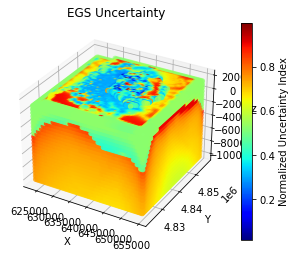

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = ax.scatter(full_data_egs_uncert[xcol], 
           full_data_egs_uncert[ycol], 
           full_data_egs_uncert[zcol],
          c=full_data_egs_uncert[valcol1],
          cmap='jet')

plt.title('EGS Uncertainty')
fig.colorbar(img, ax=ax,label='Normalized Uncertainty Index')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [14]:
full_data_egs_uncert.shape


(226457, 11)

### Project onto 2D Surface by summing values across all depths at each point on the surface

In [15]:
# take the sum of each column
full_data_egs_uncert_df = pd.DataFrame(full_data_egs_uncert)
sums_egs_uncert = full_data_egs_uncert_df.groupby([xcol,ycol],as_index=False).sum()
sums_egs_uncert.shape

(4352, 11)

In [16]:
len(x.unique())

64

### Plot in 2D

/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/215220887.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(xticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/215220887.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(yticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/215220887.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(xticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/215220887.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(yticks,fontsize= 12)


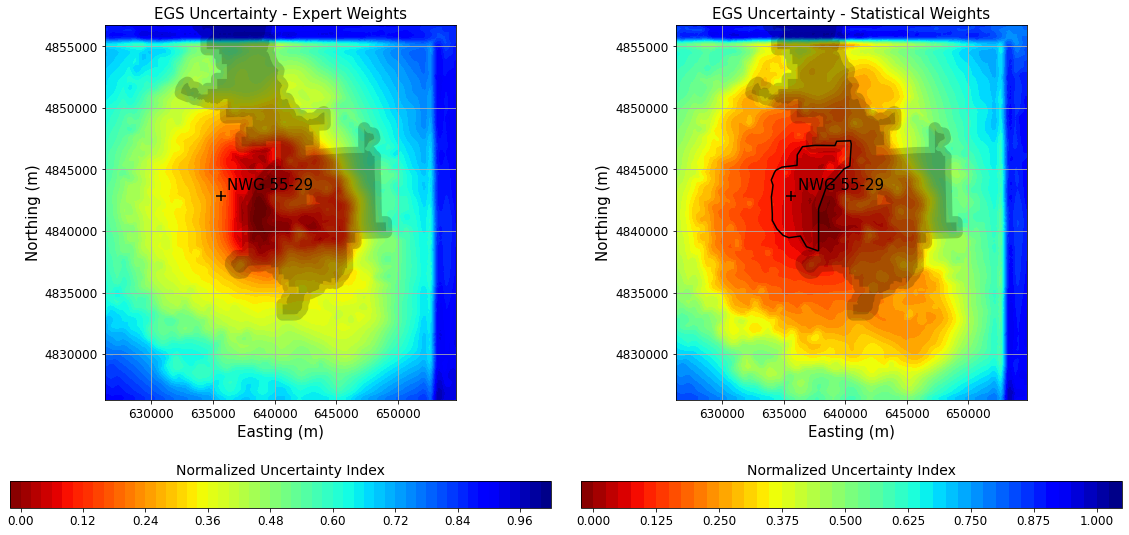

In [17]:
sums_egs_uncert = sums_egs_uncert.sort_values(by=['X','Y'])
x = sums_egs_uncert['X']
y = sums_egs_uncert['Y']
xi = np.linspace(x.min(),x.max(),500)
yi = np.linspace(y.min(),y.max(),500)
z = sums_egs_uncert['EGS Uncertainty Expert'] - sums_egs_uncert['EGS Uncertainty Expert'].min()
z = z/z.max()
xv,yv = np.meshgrid(xi,yi)
grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')

fig,ax=plt.subplots(1,2,figsize=(16,8))

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s}"

img = ax[0].contourf(xi,yi,grid,cmap='jet_r',levels=50)
# img2 = ax[0].contour(x,y,grid,colors=['lightgrey'])
# ax[0].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
xticks = [625000,630000,635000,640000,645000,650000]
yticks = [4825000, 4830000,4835000, 4840000,4845000,4850000,4855000]
ax[0].set_xlabel('Easting (m)',fontsize = 15)
ax[0].set_ylabel('Northing (m)',fontsize = 15)
ax[0].set_xticklabels(xticks,fontsize= 12)
ax[0].set_yticklabels(yticks,fontsize= 12)
ax[0].set_title('EGS Uncertainty - Expert Weights',fontsize = 15)
ax[0].xaxis.grid(True, zorder=0)
ax[0].yaxis.grid(True, zorder=0)
nnvm_boundary.plot(ax=ax[0], color='black', alpha = 0.35)
nnvm_boundary_buffer.plot(ax=ax[0], color='black', alpha = 0.2)
ax[0].set_xlim(xlim.min(), xlim.max())
ax[0].set_ylim(ylim.min(), ylim.max())
cbar = fig.colorbar(img, ax=ax[0],orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Normalized Uncertainty Index',fontsize=14)
ax[0].scatter(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m'], wells[wells['Well ID'] == 'NWG 55-29']['Northings_m'],color='black',marker='+',s=100)
ax[0].text(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m']+500, wells[wells['Well ID'] == 'NWG 55-29']['Northings_m']+500,'NWG 55-29',color='black',size=15)

z = sums_egs_uncert['EGS Uncertainty Stats'] - sums_egs_uncert['EGS Uncertainty Stats'].min()
z = z/z.max()
grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')
img = ax[1].contourf(xi,yi,grid,cmap='jet_r',levels=50)
# img2 = ax[1].contour(x,y,grid,colors=['lightgrey'])
# ax[1].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
xticks = [625000,630000,635000,640000,645000,650000]
yticks = [4825000, 4830000,4835000, 4840000,4845000,4850000,4855000]
ax[1].set_xlabel('Easting (m)',fontsize = 15)
ax[1].set_ylabel('Northing (m)',fontsize = 15)
ax[1].set_xticklabels(xticks,fontsize= 12)
ax[1].set_yticklabels(yticks,fontsize= 12)
ax[1].set_title('EGS Uncertainty - Statistical Weights',fontsize = 15)
ax[1].xaxis.grid(True, zorder=0)
ax[1].yaxis.grid(True, zorder=0)
cbar = fig.colorbar(img, ax=ax[1],orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Normalized Uncertainty Index',fontsize=14)
ax[1].scatter(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m'], wells[wells['Well ID'] == 'NWG 55-29']['Northings_m'],color='black',marker='+',s=100)
ax[1].text(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m']+500, wells[wells['Well ID'] == 'NWG 55-29']['Northings_m']+500,'NWG 55-29',color='black',size=15)

img3 = nnvm_boundary.plot(ax=ax[1], color='black', alpha = 0.35)
img4 = nnvm_boundary_buffer.plot(ax=ax[1], color='black', alpha = 0.2)  
img5 = egs_available_area.boundary.plot(ax=ax[1], color='black')                        
ax[1].set_xlim(xlim.min(), xlim.max())
ax[1].set_ylim(ylim.min(), ylim.max())

plt.tight_layout()
plt.show()

### Write 2D Projection to CSV

In [18]:
sums.to_csv('2D_'+file_path)

## Supercritical Uncertainty

### Read in file

In [19]:
# import data
file_path = 'Uncertainty - Supercritical NEW GRID.csv'
xcol = 'X'
ycol = 'Y'
zcol = 'Z'
valcol1 = 'SC Uncertainty Expert'
valcol2 = 'SC Uncertainty Stats'

full_data_sc_uncert = pd.read_csv(file_path,na_values=['WOV','OUT','BLK','ERR'])

# sort by x,y,z just in case data points are out of order
full_data_sc_uncert = full_data_sc_uncert.sort_values(by=[xcol,ycol,zcol])
full_data_sc_uncert = full_data_sc_uncert.reset_index(drop=True)
full_data_sc_uncert.head(10)

,X,Y,Z,SC Heat Uncertainty Expert,SC Reservoir Uncertainty Expert,SC Insulation Uncertainty Expert,SC Heat Uncertainty Stats,SC Reservoir Uncertainty Stats,SC Insulation Uncertainty Stats,SC Uncertainty Expert,SC Uncertainty Stats
0,623246.4,4823247.1,-24148,NaN,0.884240,0.514932,NaN,0.702009,0.913703,NaN,NaN
1,623246.4,4823247.1,-23648,NaN,0.885221,0.514432,NaN,0.703107,0.913614,NaN,NaN
2,623246.4,4823247.1,-23148,NaN,0.886275,0.514196,NaN,0.704405,0.913572,NaN,NaN
3,623246.4,4823247.1,-22648,NaN,0.887403,0.514198,NaN,0.705895,0.913573,NaN,NaN
4,623246.4,4823247.1,-22148,NaN,0.888605,0.514411,NaN,0.707564,0.913611,NaN,NaN
5,623246.4,4823247.1,-21648,NaN,0.889266,0.514812,NaN,0.708592,0.913682,NaN,NaN
6,623246.4,4823247.1,-21148,NaN,0.889723,0.515380,NaN,0.709417,0.913783,NaN,NaN
7,623246.4,4823247.1,-20648,NaN,0.890220,0.516103,NaN,0.710355,0.913912,NaN,NaN
8,623246.4,4823247.1,-20148,NaN,0.890757,0.516973,NaN,0.711403,0.914066,NaN,NaN
9,623246.4,4823247.1,-19648,NaN,0.891327,0.517986,NaN,0.712551,0.914247,NaN,NaN


### Plot in 3D for Sanity Check

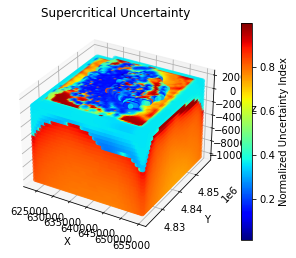

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = ax.scatter(full_data_sc_uncert[xcol], 
           full_data_sc_uncert[ycol], 
           full_data_sc_uncert[zcol],
          c=full_data_sc_uncert[valcol1],
          cmap='jet')

plt.title('Supercritical Uncertainty')
fig.colorbar(img, ax=ax,label='Normalized Uncertainty Index')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [21]:
full_data_sc_uncert.shape


(226457, 11)

### Project onto 2D Surface by summing values across all depths at each point on the surface

In [22]:
# take the sum of each column
full_data_sc_uncert_df = pd.DataFrame(full_data_sc_uncert)
sums_sc_uncert = full_data_sc_uncert_df.groupby([xcol,ycol],as_index=False).sum()


### Plot in 2D

/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/2689128892.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(xticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/2689128892.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(yticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/2689128892.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(xticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/2689128892.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(yticks,fontsize= 12)


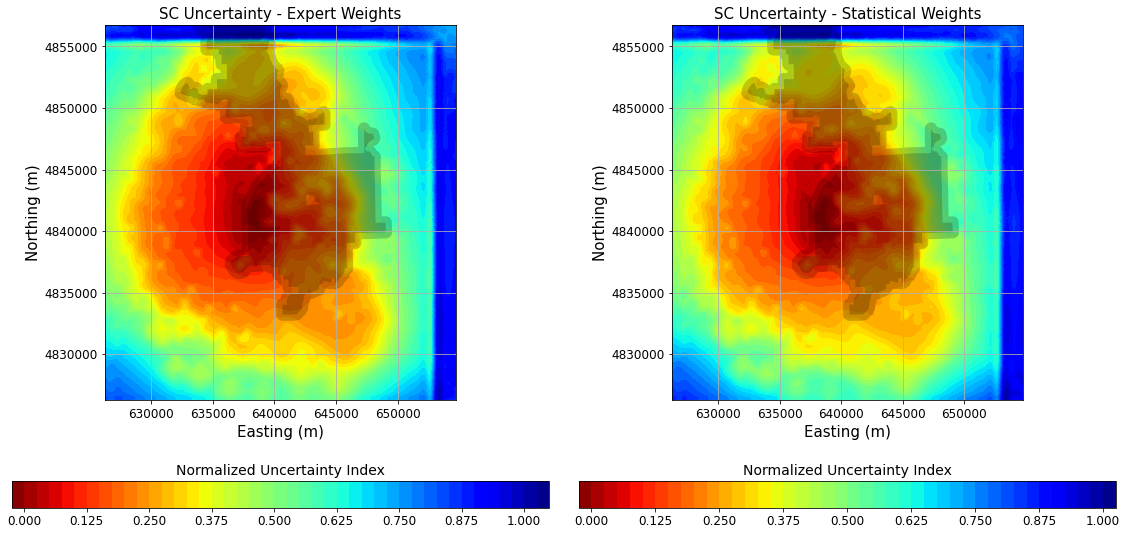

In [23]:
x = sums_sc_uncert['X']
y = sums_sc_uncert['Y']
xi = np.linspace(x.min(),x.max(),500)
yi = np.linspace(y.min(),y.max(),500)
z = sums_sc_uncert['SC Uncertainty Expert'] - sums_sc_uncert['SC Uncertainty Expert'].min()
z = z/z.max()
xv,yv = np.meshgrid(xi,yi)
grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')

fig,ax=plt.subplots(1,2,figsize=(16,8))

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s}"

# img = ax[0].pcolor(x,y,grid,cmap='jet')
img = ax[0].contourf(xi,yi,grid,cmap='jet_r',levels=50)
# img2 = ax[0].contour(x,y,grid,colors=['lightgrey'],levels=7)
# ax[0].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
xticks = [625000,630000,635000,640000,645000,650000]
yticks = [4825000, 4830000,4835000, 4840000,4845000,4850000,4855000]
ax[0].set_xlabel('Easting (m)',fontsize = 15)
ax[0].set_ylabel('Northing (m)',fontsize = 15)
ax[0].set_xticklabels(xticks,fontsize= 12)
ax[0].set_yticklabels(yticks,fontsize= 12)
ax[0].set_title('SC Uncertainty - Expert Weights',fontsize = 15)
ax[0].xaxis.grid(True, zorder=0)
ax[0].yaxis.grid(True, zorder=0)
nnvm_boundary.plot(ax=ax[0], color='black', alpha = 0.35)
nnvm_boundary_buffer.plot(ax=ax[0], color='black', alpha = 0.2)
ax[0].set_xlim(xlim.min(), xlim.max())
ax[0].set_ylim(ylim.min(), ylim.max())
cbar = fig.colorbar(img, ax=ax[0],orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Normalized Uncertainty Index',fontsize=14)

z = sums_sc_uncert['SC Uncertainty Stats'] - sums_sc_uncert['SC Uncertainty Stats'].min()
z = z/z.max()
grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')

# img = ax[1].pcolor(x,y,grid,cmap='jet')
img = ax[1].contourf(xi,yi,grid,cmap='jet_r',levels=50)
# img2 = ax[1].contour(x,y,grid,colors=['lightgrey'],levels=7)
# ax[1].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
xticks = [625000,630000,635000,640000,645000,650000]
yticks = [4825000, 4830000,4835000, 4840000,4845000,4850000,4855000]
ax[1].set_xlabel('Easting (m)',fontsize = 15)
ax[1].set_ylabel('Northing (m)',fontsize = 15)
ax[1].set_xticklabels(xticks,fontsize= 12)
ax[1].set_yticklabels(yticks,fontsize= 12)
ax[1].set_title('SC Uncertainty - Statistical Weights',fontsize = 15)
ax[1].xaxis.grid(True, zorder=0)
ax[1].yaxis.grid(True, zorder=0)
nnvm_boundary.plot(ax=ax[1], color='black', alpha = 0.35)
nnvm_boundary_buffer.plot(ax=ax[1], color='black', alpha = 0.2)
ax[1].set_xlim(xlim.min(), xlim.max())
ax[1].set_ylim(ylim.min(), ylim.max())
cbar = fig.colorbar(img, ax=ax[1],orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Normalized Uncertainty Index',fontsize=14)

plt.tight_layout()
plt.show()

### Write 2D Projection to CSV

In [24]:
sums_sc_uncert.to_csv('2D_'+file_path)

# Favorability Modeling
## Hydrothermal Favorability

### Read in file

In [25]:
# import data
file_path = 'Hydrothermal Block Model_with Components.csv'
xcol = 'X'
ycol = 'Y'
zcol = 'Z'
valcol1 = 'HT_Favorability_expert'
# valcol2 = 'HT_Favorability_stats'

full_data = pd.read_csv(file_path,na_values=['WOV','OUT','BLK','ERR'],dtype='float')
full_data = full_data[full_data['HT_Favorability_expert'].notna()]

# sort by x,y,z just in case data points are out of order
full_data = full_data.sort_values(by=[xcol,ycol,zcol])
full_data = full_data.reset_index(drop=True)
full_data.head(10)

,X,Y,Z,HT_Expert_Res,HT_Expert_HeatSource,HT_Favorability_expert
0,626246.4,4826247.1,-5648.0,0.428441,0.722103,0.588713
1,626246.4,4826247.1,-5148.0,0.486810,0.787554,0.654713
2,626246.4,4826247.1,-4648.0,0.486810,0.765665,0.645271
3,626246.4,4826247.1,-4148.0,0.428441,0.700215,0.579271
4,626246.4,4826247.1,-3648.0,0.428441,0.640129,0.553352
5,626246.4,4826247.1,-3148.0,0.486810,0.705579,0.619352
6,626246.4,4826247.1,-2648.0,0.445118,0.613948,0.552849
7,626246.4,4826247.1,-2148.0,0.461795,0.000000,0.298804
8,626246.4,4826247.1,-1648.0,0.478472,0.000000,0.309594
9,626246.4,4826247.1,-1148.0,0.511825,0.000000,0.331176


### Plot in 3D for Sanity Check

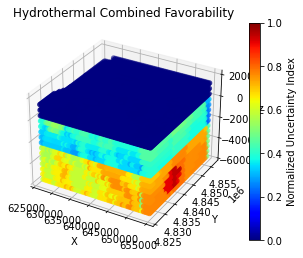

In [26]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = ax.scatter(full_data[xcol], 
           full_data[ycol], 
           full_data[zcol],
          c=full_data[valcol1],
          cmap='jet')

# Combined implies weights sum of component favorability models
plt.title('Hydrothermal Combined Favorability')
fig.colorbar(img, ax=ax,label='Normalized Uncertainty Index')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [27]:
full_data.shape


(54466, 6)

### Project onto 2D Surface by summing values across all depths at each point on the surface

In [28]:
# take the sum of each column
full_data_df = pd.DataFrame(full_data)
sums = full_data_df.groupby([xcol,ycol],as_index=False).sum()

### Normalize

In [29]:
sums_ht_uncert['HT Uncertainty Expert'] -= sums_ht_uncert['HT Uncertainty Expert'].min()
sums_ht_uncert['HT Uncertainty Expert'] /= sums_ht_uncert['HT Uncertainty Expert'].max()
mask_ht_expert = sums_ht_uncert[sums_ht_uncert['HT Uncertainty Expert'] > 0.35]

### Plot in 2D

/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/4284554291.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(xticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/4284554291.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(yticks,fontsize= 12)


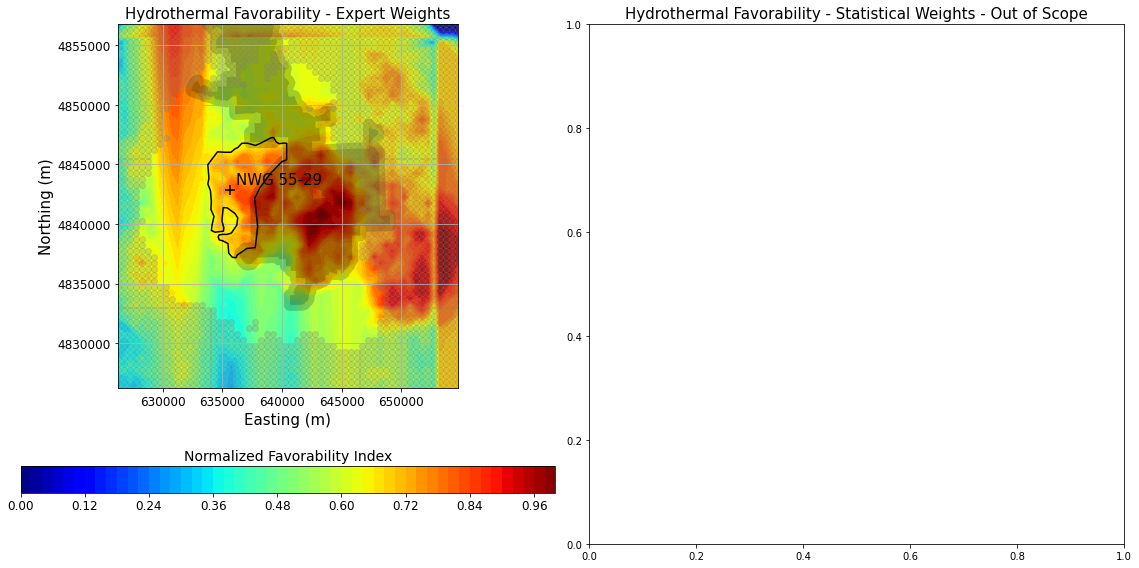

In [30]:
x = sums['X']
y = sums['Y']
z = sums['HT_Favorability_expert'] - sums['HT_Favorability_expert'].min()
z = z/z.max()
xv,yv = np.meshgrid(x,y)
grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')

fig,ax=plt.subplots(1,2,figsize=(16,8))

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s}"

img = ax[0].contourf(x,y,grid,cmap='jet',levels=50)
# img2 = ax[0].contour(x,y,grid,colors=['lightgrey'])
# ax[0].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
xticks = [625000,630000,635000,640000,645000,650000]
yticks = [4825000, 4830000,4835000, 4840000,4845000,4850000,4855000]
ax[0].set_xlabel('Easting (m)',fontsize = 15)
ax[0].set_ylabel('Northing (m)',fontsize = 15)
ax[0].set_xticklabels(xticks,fontsize= 12)
ax[0].set_yticklabels(yticks,fontsize= 12)
ax[0].set_title('Hydrothermal Favorability - Expert Weights',fontsize = 15)
ax[0].xaxis.grid(True, zorder=0)
ax[0].yaxis.grid(True, zorder=0)
nnvm_boundary.plot(ax=ax[0], color='black', alpha = 0.35)
nnvm_boundary_buffer.plot(ax=ax[0], color='black', alpha = 0.2)
hydrothermal_available_area.boundary.plot(ax=ax[0], color='black')
ax[0].scatter(mask_ht_expert['X'],mask_ht_expert['Y'],color='gray', alpha=0.25)
ax[0].scatter(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m'], wells[wells['Well ID'] == 'NWG 55-29']['Northings_m'],color='black',marker='+',s=100)
ax[0].text(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m']+500, wells[wells['Well ID'] == 'NWG 55-29']['Northings_m']+500,'NWG 55-29',color='black',size=15)
ax[0].set_xlim(x.min(), x.max())
ax[0].set_ylim(y.min(), y.max())
cbar = fig.colorbar(img, ax=ax[0],orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Normalized Favorability Index',fontsize=14)

# z = sums['EGS_Favorability_stats'] - sums['EGS_Favorability_stats'].min()
# z = z/z.max()
# grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')
# img = ax[1].contourf(x,y,grid,cmap='jet')
# # img2 = ax[1].contour(x,y,grid,colors=['lightgrey'])
# # ax[1].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
# ax[1].set_xlabel('Easting (m)')
# ax[1].set_ylabel('Northing (m)')
ax[1].set_title('Hydrothermal Favorability - Statistical Weights - Out of Scope',fontsize = 15)
# fig.colorbar(img, ax=ax[1])

plt.tight_layout()
plt.show()

### Write 2D Projection to CSV and export figures

In [32]:
image_format = 'jpeg' # e.g .png, .svg, etc.
image_name = 'hydrothermal_favorability.jpeg'

fig.savefig(image_name, format=image_format, dpi=1200)

sums_ht_uncert.to_csv('2D_'+file_path)

## EGS Favorability

### Read in file

In [33]:
# import data
file_path = 'EGS Block Model_with Components.csv'
xcol = 'X'
ycol = 'Y'
zcol = 'Z'
valcol1 = 'EGS_Favorability_expert'
valcol2 = 'EGS_Favorability_stats'

full_data = pd.read_csv(file_path,na_values=['WOV','OUT','BLK','ERR'])

# sort by x,y,z just in case data points are out of order
full_data = full_data.sort_values(by=[xcol,ycol,zcol])
full_data = full_data.reset_index(drop=True)
full_data.head(10)

,X,Y,Z,EGS_Expert_Res,EGS_Expert_HeatSource,EGS_Expert_Insulation,EGS_Stats_Res,EGS_Stats_HeatSource,EGS_Stats_Insulation,EGS_Favorability_expert,EGS_Favorability_stats
0,626246.4,4826247.1,-5648,0.493036,0.720835,0.706631,0.589740,0.791899,0.654040,0.756696,0.841808
1,626246.4,4826247.1,-5148,0.482823,0.689360,0.724003,0.549871,0.806949,0.697063,0.740762,0.840178
2,626246.4,4826247.1,-4648,0.482823,0.611700,0.724003,0.549871,0.751951,0.697063,0.703265,0.813082
3,626246.4,4826247.1,-4148,0.493036,0.573384,0.706631,0.589740,0.712003,0.654040,0.685501,0.802445
4,626246.4,4826247.1,-3648,0.493036,0.503592,0.706631,0.589740,0.687105,0.654040,0.651804,0.790179
5,626246.4,4826247.1,-3148,0.482823,0.541909,0.724003,0.549871,0.727053,0.697063,0.669567,0.800815
6,626246.4,4826247.1,-2648,0.468431,0.557646,0.676291,0.571915,0.700111,0.623084,0.658698,0.780179
7,626246.4,4826247.1,-2148,0.443825,0.000000,0.736971,0.544564,0.000000,0.684997,0.392214,0.437030
8,626246.4,4826247.1,-1648,0.419220,0.000000,0.750428,0.526738,0.000000,0.697260,0.383583,0.431269
9,626246.4,4826247.1,-1148,0.370009,0.000000,0.780768,0.481562,0.000000,0.728217,0.367146,0.416638


### Plot in 3D for Sanity Check

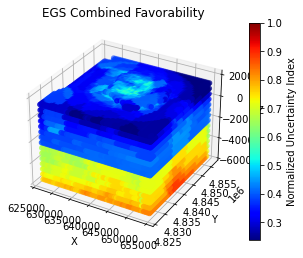

In [34]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = ax.scatter(full_data[xcol], 
           full_data[ycol], 
           full_data[zcol],
          c=full_data[valcol1],
          cmap='jet')

# Combined implies weights sum of component favorability models
plt.title('EGS Combined Favorability')
fig.colorbar(img, ax=ax,label='Normalized Uncertainty Index')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [35]:
full_data.shape


(54484, 11)

### Project onto 2D Surface by summing values across all depths at each point on the surface

In [36]:
# take the sum of each column
full_data_df = pd.DataFrame(full_data)
sums = full_data_df.groupby([xcol,ycol],as_index=False).sum()


### Normalize

In [37]:
sums_egs_uncert['EGS Uncertainty Expert'] -= sums_egs_uncert['EGS Uncertainty Expert'].min()
sums_egs_uncert['EGS Uncertainty Expert'] /= sums_egs_uncert['EGS Uncertainty Expert'].max()
mask_egs_expert = sums_egs_uncert[sums_egs_uncert['EGS Uncertainty Expert'] > 0.35]

sums_egs_uncert['EGS Uncertainty Stats'] -= sums_egs_uncert['EGS Uncertainty Stats'].min()
sums_egs_uncert['EGS Uncertainty Stats'] /= sums_egs_uncert['EGS Uncertainty Stats'].max()
mask_egs_stats = sums_egs_uncert[sums_egs_uncert['EGS Uncertainty Stats'] > 0.35]

### Plot in 2D

In [38]:
wells[wells['Well ID'] == 'NWG 55-29']

,Well ID,Eastings_m,Northings_m,Elevation,z_on_terrain,maxdepth
0,NWG 55-29,635642.0,4842835.0,0.0,1772.519675,3068.0


/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/1023222979.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(xticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/1023222979.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(yticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/1023222979.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(xticks,fontsize= 12)
/var/folders/vy/6hx13qss2574cy4cxkqnjhn9grt3m4/T/ipykernel_20691/1023222979.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(yticks,fontsize= 12)


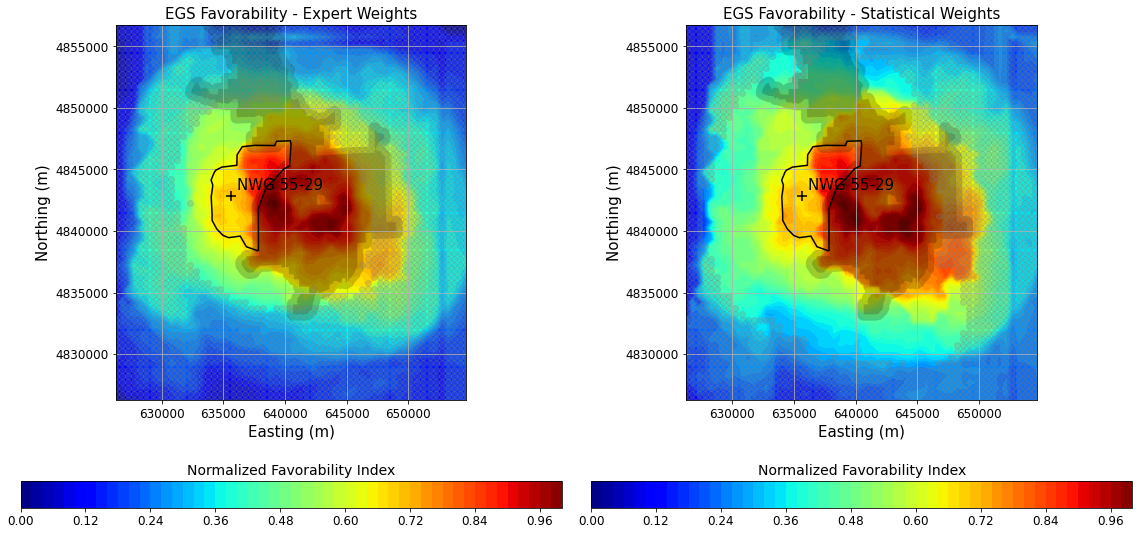

In [39]:
x = sums['X']
y = sums['Y']
z = sums['EGS_Favorability_expert'] - sums['EGS_Favorability_expert'].min()
z = z/z.max()
xv,yv = np.meshgrid(x,y)
grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')

fig,ax=plt.subplots(1,2,figsize=(16,8))

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s}"

img = ax[0].contourf(x,y,grid,cmap='jet',levels=50)
# img2 = ax[0].contour(x,y,grid,colors=['lightgrey'])
# ax[0].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
xticks = [625000,630000,635000,640000,645000,650000]
yticks = [4825000, 4830000,4835000, 4840000,4845000,4850000,4855000]
ax[0].set_xlabel('Easting (m)',fontsize = 15)
ax[0].set_ylabel('Northing (m)',fontsize = 15)
ax[0].set_xticklabels(xticks,fontsize= 12)
ax[0].set_yticklabels(yticks,fontsize= 12)
ax[0].set_title('EGS Favorability - Expert Weights',fontsize = 15)
ax[0].xaxis.grid(True, zorder=0)
ax[0].yaxis.grid(True, zorder=0)
nnvm_boundary.plot(ax=ax[0], color='black', alpha = 0.35)
nnvm_boundary_buffer.plot(ax=ax[0], color='black', alpha = 0.2)
egs_available_area.boundary.plot(ax=ax[0], color='black')
ax[0].scatter(mask_egs_expert['X'],mask_egs_expert['Y'],color='gray', alpha=0.25)
ax[0].scatter(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m'], wells[wells['Well ID'] == 'NWG 55-29']['Northings_m'],color='black',marker='+',s=100)
ax[0].text(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m']+500, wells[wells['Well ID'] == 'NWG 55-29']['Northings_m']+500,'NWG 55-29',color='black',size=15)
ax[0].set_xlim(x.min(), x.max())
ax[0].set_ylim(y.min(), y.max())
cbar = fig.colorbar(img, ax=ax[0],orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Normalized Favorability Index',fontsize=14)

z = sums['EGS_Favorability_stats'] - sums['EGS_Favorability_stats'].min()
z = z/z.max()
grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')
img = ax[1].contourf(x,y,grid,cmap='jet',levels=50)
# img2 = ax[1].contour(x,y,grid,colors=['lightgrey'])
# ax[1].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
xticks = [625000,630000,635000,640000,645000,650000]
yticks = [4825000, 4830000,4835000, 4840000,4845000,4850000,4855000]
ax[1].set_xlabel('Easting (m)',fontsize = 15)
ax[1].set_ylabel('Northing (m)',fontsize = 15)
ax[1].set_xticklabels(xticks,fontsize= 12)
ax[1].set_yticklabels(yticks,fontsize= 12)
ax[1].set_title('EGS Favorability - Statistical Weights',fontsize = 15)
ax[1].xaxis.grid(True, zorder=0)
ax[1].yaxis.grid(True, zorder=0)
nnvm_boundary.plot(ax=ax[1], color='black', alpha = 0.35)
nnvm_boundary_buffer.plot(ax=ax[1], color='black', alpha = 0.2)         
egs_available_area.boundary.plot(ax=ax[1], color='black')                 
ax[1].scatter(mask_egs_stats['X'],mask_egs_stats['Y'],color='gray', alpha=0.25)
ax[1].scatter(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m'], wells[wells['Well ID'] == 'NWG 55-29']['Northings_m'],color='black',marker='+',s=100)
ax[1].text(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m']+500, wells[wells['Well ID'] == 'NWG 55-29']['Northings_m']+500,'NWG 55-29',color='black',size=15)
ax[1].set_xlim(x.min(), x.max())
ax[1].set_ylim(y.min(), y.max())
cbar = fig.colorbar(img, ax=ax[1],orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Normalized Favorability Index',fontsize=14)

plt.tight_layout()
plt.show()

### Write 2D Projection to CSV and export figures

In [41]:
image_format = 'jpeg' # e.g .png, .svg, etc.
image_name = 'egs_favorability.jpeg'

fig.savefig(image_name, format=image_format, dpi=1200)

sums_ht_uncert.to_csv('2D_'+file_path)

## Supercritical Favorability

### Read in file

In [ ]:
# import data
file_path = 'Supercritical Block Model_with Components.csv'
xcol = 'X'
ycol = 'Y'
zcol = 'Z'
valcol1 = 'SC_Favorability_expert'
valcol2 = 'SC_Favorability_stats'

full_data = pd.read_csv(file_path,na_values=['WOV','OUT','BLK','ERR'])

# sort by x,y,z just in case data points are out of order
full_data = full_data.sort_values(by=[xcol,ycol,zcol])
full_data = full_data.reset_index(drop=True)
full_data.head(10)

### Plot in 3D for Sanity Check

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = ax.scatter(full_data[xcol], 
           full_data[ycol], 
           full_data[zcol],
          c=full_data[valcol1],
          cmap='jet')

# Combined implies weights sum of component favorability models
plt.title('Supercritical Combined Favorability')
fig.colorbar(img, ax=ax,label='Normalized Uncertainty Index')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
full_data.shape


### Project onto 2D Surface by summing values across all depths at each point on the surface

In [ ]:
# take the sum of each column
full_data_df = pd.DataFrame(full_data)
sums = full_data_df.groupby([xcol,ycol],as_index=False).sum()

### Normalize

In [ ]:
sums_sc_uncert['SC Uncertainty Expert'] -= sums_sc_uncert['SC Uncertainty Expert'].min()
sums_sc_uncert['SC Uncertainty Expert'] /= sums_sc_uncert['SC Uncertainty Expert'].max()
mask_sc_expert = sums_sc_uncert[sums_sc_uncert['SC Uncertainty Expert'] > 0.35]

sums_sc_uncert['SC Uncertainty Stats'] -= sums_sc_uncert['SC Uncertainty Stats'].min()
sums_sc_uncert['SC Uncertainty Stats'] /= sums_sc_uncert['SC Uncertainty Stats'].max()
mask_sc_stats = sums_sc_uncert[sums_sc_uncert['SC Uncertainty Stats'] > 0.35]

### Plot in 2D

In [ ]:
x = sums['X']
y = sums['Y']
z = sums['SC_Favorability_expert'] - sums['SC_Favorability_expert'].min()
z = z/z.max()
xv,yv = np.meshgrid(x,y)
grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')

fig,ax=plt.subplots(1,2,figsize=(16,8))

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s}"

# img = ax[0].pcolor(x,y,grid,cmap='jet')
img = ax[0].contourf(x,y,grid,cmap='jet',levels=50)
# img2 = ax[0].contour(x,y,grid,colors=['lightgrey'],levels=7)
# ax[0].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
xticks = [625000,630000,635000,640000,645000,650000]
yticks = [4825000, 4830000,4835000, 4840000,4845000,4850000,4855000]
ax[0].set_xlabel('Easting (m)',fontsize = 15)
ax[0].set_ylabel('Northing (m)',fontsize = 15)
ax[0].set_xticklabels(xticks,fontsize= 12)
ax[0].set_yticklabels(yticks,fontsize= 12)
ax[0].set_title('SC Favorability - Expert Weights',fontsize = 15)
ax[0].xaxis.grid(True, zorder=0)
ax[0].yaxis.grid(True, zorder=0)
nnvm_boundary.plot(ax=ax[0], color='black', alpha = 0.35)
nnvm_boundary_buffer.plot(ax=ax[0], color='black', alpha = 0.2)
ax[0].scatter(mask_egs_expert['X'],mask_egs_expert['Y'],color='gray', alpha=0.25)
ax[0].scatter(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m'], wells[wells['Well ID'] == 'NWG 55-29']['Northings_m'],color='black',marker='+',s=100)
ax[0].text(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m']+500, wells[wells['Well ID'] == 'NWG 55-29']['Northings_m']+500,'NWG 55-29',color='black',size=15)
ax[0].set_xlim(x.min(), x.max())
ax[0].set_ylim(y.min(), y.max())
cbar = fig.colorbar(img, ax=ax[0],orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Normalized Favorability Index',fontsize=14)

z = sums['SC_Favorability_stats'] - sums['SC_Favorability_stats'].min()
z = z/z.max()
grid = scipy.interpolate.griddata((x,y), z, (xv, yv), method='cubic')

# img = ax[1].pcolor(x,y,grid,cmap='jet')
img = ax[1].contourf(x,y,grid,cmap='jet',levels=50)
# img2 = ax[1].contour(x,y,grid,colors=['lightgrey'],levels=7)
# ax[1].clabel(img2, img2.levels, inline=True, fmt=fmt, fontsize=10)
xticks = [625000,630000,635000,640000,645000,650000]
yticks = [4825000, 4830000,4835000, 4840000,4845000,4850000,4855000]
ax[1].set_xlabel('Easting (m)',fontsize = 15)
ax[1].set_ylabel('Northing (m)',fontsize = 15)
ax[1].set_xticklabels(xticks,fontsize= 12)
ax[1].set_yticklabels(yticks,fontsize= 12)
ax[1].set_title('SC Favorability - Statistical Weights',fontsize = 15)
ax[1].xaxis.grid(True, zorder=0)
ax[1].yaxis.grid(True, zorder=0)
nnvm_boundary.plot(ax=ax[1], color='black', alpha = 0.35)
nnvm_boundary_buffer.plot(ax=ax[1], color='black', alpha = 0.2)
ax[1].scatter(mask_egs_stats['X'],mask_egs_stats['Y'],color='gray', alpha=0.25)
ax[1].scatter(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m'], wells[wells['Well ID'] == 'NWG 55-29']['Northings_m'],color='black',marker='+',s=100)
ax[1].text(wells[wells['Well ID'] == 'NWG 55-29']['Eastings_m']+500, wells[wells['Well ID'] == 'NWG 55-29']['Northings_m']+500,'NWG 55-29',color='black',size=15)
ax[1].set_xlim(x.min(), x.max())
ax[1].set_ylim(y.min(), y.max())
cbar = fig.colorbar(img, ax=ax[1],orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Normalized Favorability Index',fontsize=14)

plt.tight_layout()
plt.show()

### Write 2D Projection to CSV

In [ ]:
sums.to_csv('2D_'+file_path)